In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm

import warnings
warnings.simplefilter("ignore")

plt.style.use('ggplot')

# 1. Snow cover
We start by listing out the stations in the three regions:

In [2]:
stationsNorth = ['ADM', 'BFL', 'BKL', 'BMW', 'BNK', 'CDP', 'DSS', 'FOR', 'GOL', 'GRZ', 'HIG', 'HMB', 'IDC', 'IDP',
                 'INN', 'LLP', 'MED', 'NLS', 'PLP', 'RRM', 'RTL', 'SLT', 'SNM', 'SQV', 'TK2']
stationsCentral = ['ALP', 'BLC', 'BLD', 'BLK', 'BLS', 'BSK', 'CAP', 'CSL', 'CXS', 'DAN', 'DDM', 'EBB', 'EP5', 'FDC',
                   'FLL', 'FRN', 'GKS', 'GNL', 'HGM', 'HOR', 'HRS', 'HVN', 'HYS', 'KIB', 'LBD', 'LVM', 'LVT', 'MDW',
                   'MNT', 'MRL', 'MSK', 'PDS', 'PSN', 'RBB', 'RBP', 'RCC', 'RP2', 'SDW', 'SIL', 'SLI', 'SPS', 'SPT',
                   'STR', 'TCC', 'TNY', 'TUM', 'VRG', 'VVL', 'WC3', 'WHW']
stationsSouth = ['BCB', 'BCH', 'BGP', 'BSH', 'CBT', 'CHM', 'CHP', 'CRL', 'CSV', 'CWD', 'FRW', 'GNF', 'GRM', 'GRV', 'HNT',
                 'KSP', 'MHP', 'PSC', 'PSR', 'RCK', 'SLK', 'STL', 'SWM', 'TMR', 'TUN', 'UTY', 'WTM', 'WWC']

We iterate through all stations and import into dataframes for each region:

In [3]:
dataNorth = pd.DataFrame() # import North stations
for station in tqdm.tqdm(stationsNorth):
    table = pd.read_excel('SnowcoverData/' + station + '_3.xlsx')
    dataNorth = pd.concat([dataNorth, table])
    
dataCentral = pd.DataFrame() # import Central stations
for station in tqdm.tqdm(stationsCentral):
    table = pd.read_excel('SnowcoverData/' + station + '_3.xlsx')
    dataCentral = pd.concat([dataCentral, table])
    
dataSouth = pd.DataFrame() # import South stations
for station in tqdm.tqdm(stationsSouth):
    table = pd.read_excel('SnowcoverData/' + station + '_3.xlsx')
    dataSouth = pd.concat([dataSouth, table])
    
len(dataNorth), len(dataCentral), len(dataSouth)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:24<00:00,  1.13it/s]


(120050, 240100, 134456)

We perform some data cleaning:
- delete all data flagged as erroneous (`DATA_FLAG` = `N`)
- deleting all NaNs in the `VALUE` column
- applying a correction for `dataCentral` as the `VALUE` column contains commas as the thousands separator and therefore is a string column
- deleting anomalous values of snow cover (eg. > 150 inches and < -10 inches)

In [63]:
dataNorth = dataNorth[dataNorth['DATA_FLAG'] != 'N'] # eliminate erroneous values
dataNorth = dataNorth[~dataNorth['VALUE'].isna()] # eliminate NaNs
dataNorth = dataNorth[(dataNorth['VALUE'] < 150) & (dataNorth['VALUE'] > -10)] # eliminate anomalous values

dataCentral = dataCentral[dataCentral['DATA_FLAG'] != 'N'] # eliminate erroneous values
dataCentral = dataCentral[~dataCentral['VALUE'].isna()] # eliminate NaNs
dataCentral['VALUE'] = dataCentral['VALUE'].apply(lambda x: x.replace(',',
                '') if isinstance(x, str) else x).astype(float) # convert str to float
dataCentral = dataCentral[(dataCentral['VALUE'] < 150) & (dataCentral['VALUE'] > -10)] # eliminate anomalous values

dataSouth = dataSouth[dataSouth['DATA_FLAG'] != 'N'] # eliminate erroneous values
dataSouth = dataSouth[~dataSouth['VALUE'].isna()] # eliminate NaNs
dataSouth = dataSouth[(dataSouth['VALUE'] < 150) & (dataSouth['VALUE'] > -10)] # eliminate anomalous values

len(dataNorth), len(dataCentral), len(dataSouth)

(108947, 213539, 119254)

All data in the table is for `SNOW WC` (snow water cover) in inches, at daily resolution. We can drop unnecessary columns from all 3 dataframes.

In [68]:
for df in [dataNorth, dataCentral, dataSouth]:
    df.drop(columns=['DURATION', 'SENSOR_NUMBER', 'SENS_TYPE', 'OBS DATE', 'DATA_FLAG', 'UNITS'], inplace=True)

We now convert the `DATE TIME` column into a datetime (`dt`) and group by week.

In [69]:
dataNorth['dt'] = pd.to_datetime(dataNorth['DATE TIME'])
dataCentral['dt'] = pd.to_datetime(dataCentral['DATE TIME'])
dataSouth['dt'] = pd.to_datetime(dataSouth['DATE TIME'])

weeklyNorth = dataNorth.groupby(pd.Grouper(key='dt', freq='W')).mean()
weeklyCentral = dataCentral.groupby(pd.Grouper(key='dt', freq='W')).mean()
weeklySouth = dataSouth.groupby(pd.Grouper(key='dt', freq='W')).mean()

len(weeklyNorth), len(weeklyCentral), len(weeklySouth)

(687, 687, 687)

Now we can plot the average snow cover for each region over the time period:

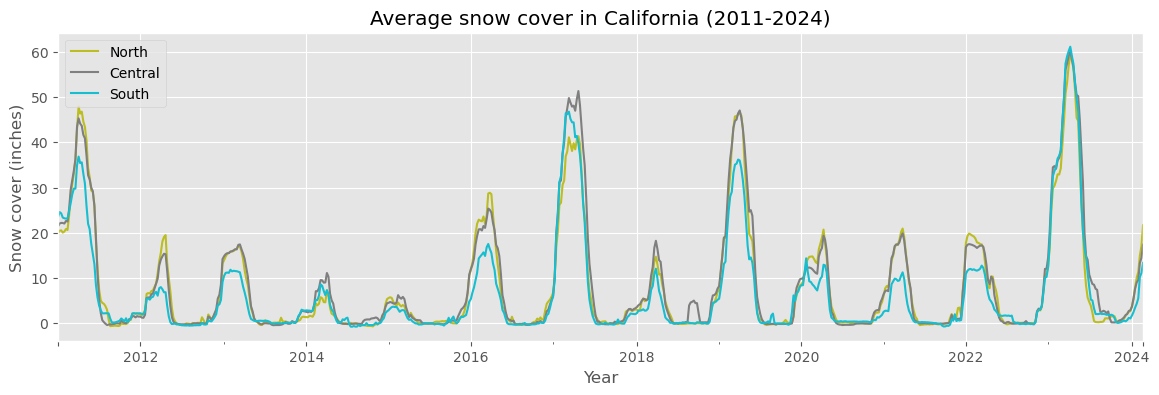

In [99]:
fig,ax = plt.subplots(figsize=(14,4))

weeklyNorth.plot(ax=ax, color='tab:olive')
weeklyCentral.plot(ax=ax, color='tab:gray')
weeklySouth.plot(ax=ax, color='tab:cyan')

plt.legend(['North','Central','South'])
plt.xlabel('Year')
plt.ylabel('Snow cover (inches)')
plt.title('Average snow cover in California (2011-2024)')
plt.show()

We can merge all three dataframes into one, `weeklySnow`, and save to csv:

In [129]:
weeklyNorth.rename(columns={'VALUE':'North'}, inplace=True)
weeklyCentral.rename(columns={'VALUE':'Central'}, inplace=True)
weeklySouth.rename(columns={'VALUE':'South'}, inplace=True)

weeklySnow = pd.DataFrame()
weeklySnow['North'] = weeklyNorth['North']
weeklySnow['Central'] = weeklyCentral['Central']
weeklySnow['South'] = weeklySouth['South']

len(weeklySnow)

687

In [122]:
weeklySnow.to_csv('WeeklyAvgSnowCover.csv')

# 2. Hydropower
We start by importing data from CAISO, from the 'Production' sheet of the Excel files. These data are reported in MW, so it represents **power** generated, at 5 minute intervals.

In [145]:
years = ['2023','2022','2021','2020','2019','2018','Jun2017-Dec2017','May2014-May2017']

hydro = pd.DataFrame()
for year in tqdm.tqdm(years):
    table = pd.read_excel('HydropowerData/ProductionAndCurtailmentsData_' + year + '.xlsx', sheet_name='Production')
    hydro = pd.concat([hydro, table])

len(hydro)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:13<00:00, 31.68s/it]


1017222

In [170]:
hydro = hydro[['Date','Load','Large Hydro','Generation']]
hydro.to_csv('CombinedHydroTables.csv')
hydro.head()

,Date,Load,Large Hydro,Generation
0,2023-01-01 00:00:00,21597.283125,1489.305664,15702.798424
1,2023-01-01 00:05:00,21524.660938,1433.653218,15627.185977
2,2023-01-01 00:10:00,21414.377734,1416.692908,15609.724570
3,2023-01-01 00:15:00,21325.079063,1414.016970,15594.241576
4,2023-01-01 00:20:00,21228.566927,1519.628516,15837.555872


In [171]:
hydro['hydro_pct_gen'] = hydro['Large Hydro'] / hydro['Generation'] * 100
hydro['hydro_pct_load'] = hydro['Large Hydro'] / hydro['Load'] * 100

In [160]:
weeklyHydro = hydro.groupby(pd.Grouper(key='Date', freq='W')).mean()

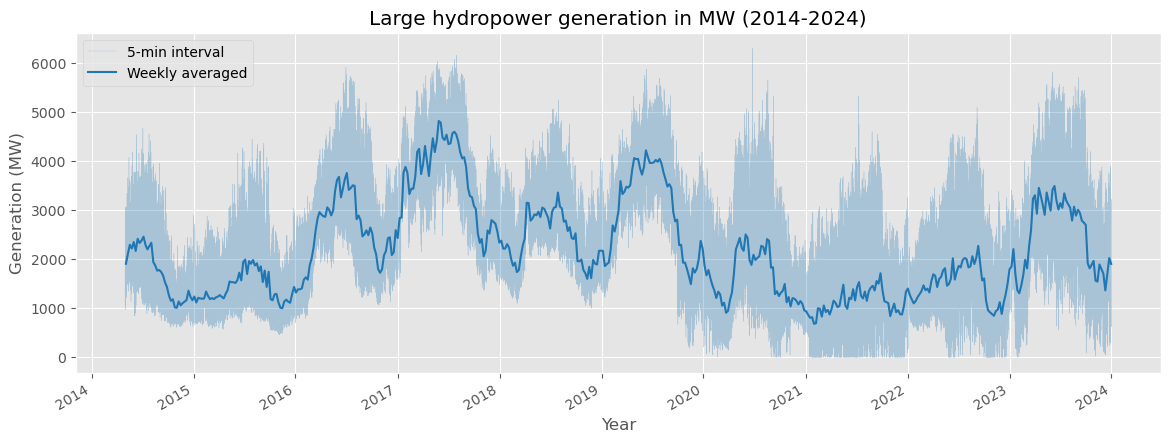

In [165]:
fig,ax = plt.subplots(figsize=(14,5))
hydro.plot(x='Date', y='Large Hydro', color='tab:blue', ax=ax, alpha=0.3, lw=0.3)
weeklyHydro['Large Hydro'].plot(ax=ax, color='tab:blue')

plt.xlabel('Year')
plt.ylabel('Generation (MW)')
plt.title('Large hydropower generation in MW (2014-2024)')
plt.legend(['5-min interval','Weekly averaged'])
plt.show()

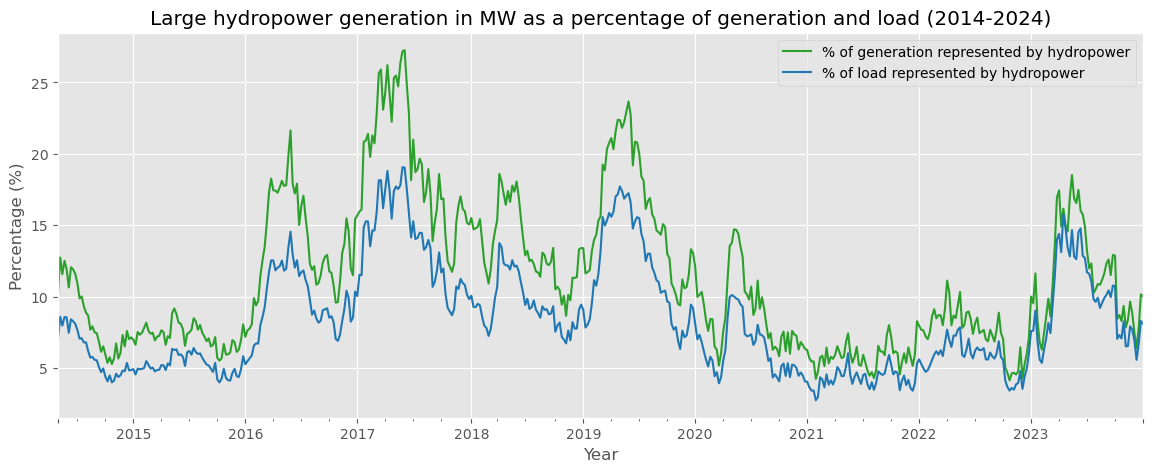

In [168]:
fig,ax = plt.subplots(figsize=(14,5))
weeklyHydro['hydro_pct_gen'].plot(ax=ax, color='tab:green')
weeklyHydro['hydro_pct_load'].plot(ax=ax, color='tab:blue')

plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Large hydropower generation in MW as a percentage of generation and load (2014-2024)')
plt.legend(['% of generation represented by hydropower','% of load represented by hydropower'])
plt.show()

# 3. Combining datasets

In [179]:
merged = pd.merge_asof(weeklySnow, weeklyHydro, left_index=True, right_index=True, direction='nearest')
merged.head()

,North,Central,South,Load,Large Hydro,Generation,hydro_pct_gen,hydro_pct_load
dt,,,,,,,,
2011-01-02,19.911250,21.419286,23.478519,26764.401608,1906.119095,18871.287779,10.223781,7.074695
2011-01-09,20.468941,22.049359,24.568289,26764.401608,1906.119095,18871.287779,10.223781,7.074695
2011-01-16,20.540977,22.188309,24.290312,26764.401608,1906.119095,18871.287779,10.223781,7.074695
2011-01-23,20.040857,22.171404,23.370306,26764.401608,1906.119095,18871.287779,10.223781,7.074695
2011-01-30,20.275314,22.039591,23.208918,26764.401608,1906.119095,18871.287779,10.223781,7.074695


In [184]:
merged['Snowpack'] = (merged['North'] + merged['Central'] + merged['South'])/3

Using twin axes to plot snowpack and hydropower generation on the same plot with different scales:

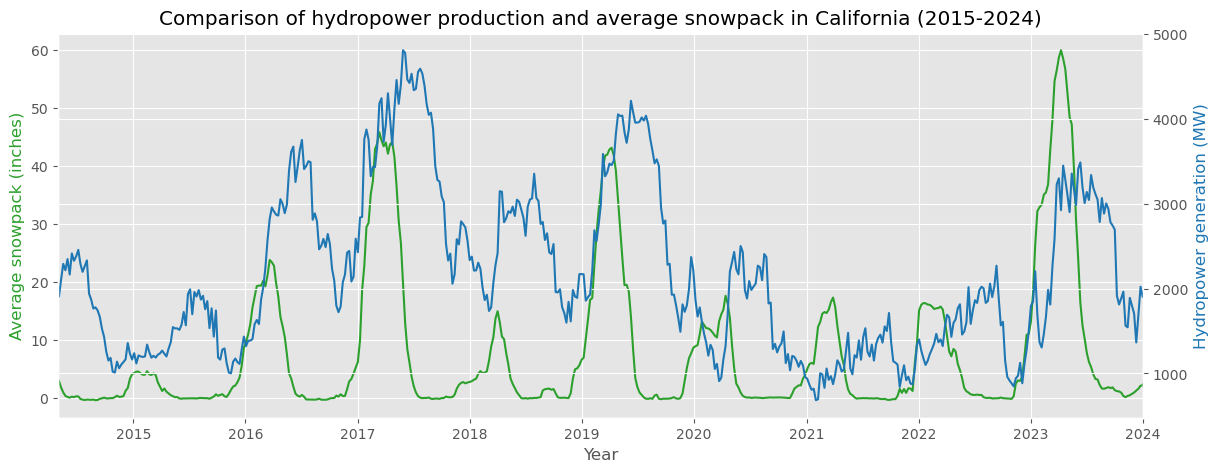

In [197]:
fig,ax = plt.subplots(figsize=(14,5))

ax.plot(merged.index, merged['Snowpack'], color='tab:green')
ax.set_xlabel('Year')
ax.set_ylabel('Average snowpack (inches)', color='tab:green')

ax2 = ax.twinx() # create a twin axis
ax2.plot(merged.index, merged['Large Hydro'], color='tab:blue')
ax2.set_ylabel('Hydropower generation (MW)', color='tab:blue')

ax.set_xlim([pd.to_datetime('05-01-2014'), pd.to_datetime('01-01-2024')])
plt.title('Comparison of hydropower production and average snowpack in California (2015-2024)')
plt.show()

We now reduce the temporal extent of `merged` to the period where all variables coincide, so as not to affect the correlation analysis that follows:

In [203]:
red_merged = merged[(merged.index > pd.to_datetime('05-01-2014')) & (merged.index < pd.to_datetime('01-01-2024'))]

Calculate the lag between two variables:

In [207]:
snowpack = red_merged['Snowpack']
large_hydro = red_merged['Large Hydro']

In [210]:
cross_corr = snowpack.corr(large_hydro, method='pearson') # cross-correlation between variables

# calculate cross-correlation lag
cross_corr_series = pd.Series([snowpack.corr(large_hydro.shift(i), method='pearson') for i in range(len(snowpack))])
max_corr_lag = cross_corr_series.idxmax()

print("Maximum correlation:", cross_corr)
print("Lag at maximum correlation:", max_corr_lag)

Maximum correlation: 0.32091220847696317
Lag at maximum correlation: 503


In [220]:
large_hydro_shifted = large_hydro.shift(-15)

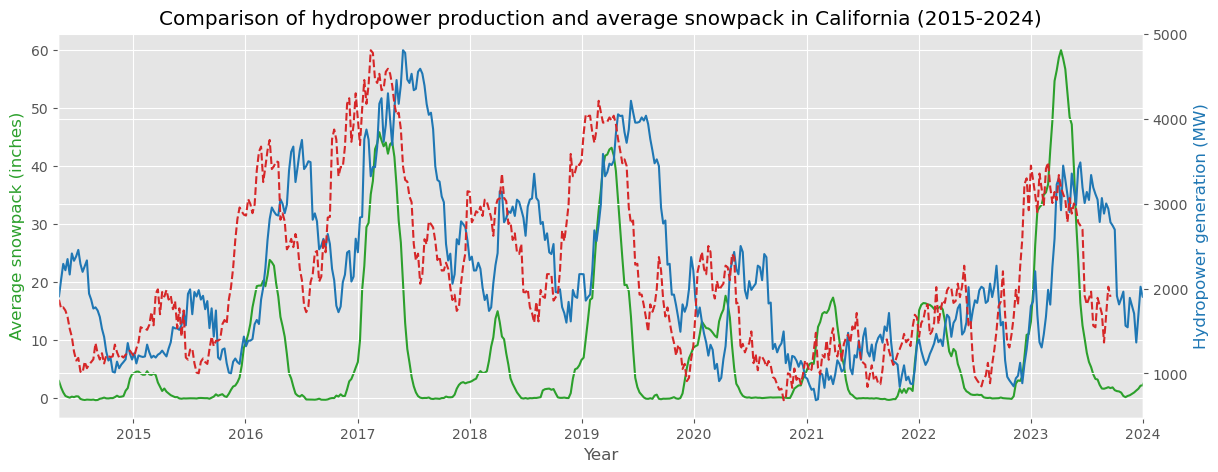

In [223]:
fig,ax = plt.subplots(figsize=(14,5))

ax.plot(merged.index, merged['Snowpack'], color='tab:green')
ax.set_xlabel('Year')
ax.set_ylabel('Average snowpack (inches)', color='tab:green')

ax2 = ax.twinx() # create a twin axis
ax2.plot(merged.index, merged['Large Hydro'], color='tab:blue')
ax2.set_ylabel('Hydropower generation (MW)', color='tab:blue')

ax2.plot(large_hydro_shifted, color='tab:red', linestyle='--')

ax.set_xlim([pd.to_datetime('05-01-2014'), pd.to_datetime('01-01-2024')])
plt.title('Comparison of hydropower production and average snowpack in California (2015-2024)')
plt.show()

In [228]:
from scipy.stats import pearsonr

In [231]:
x, y = snowpack, large_hydro

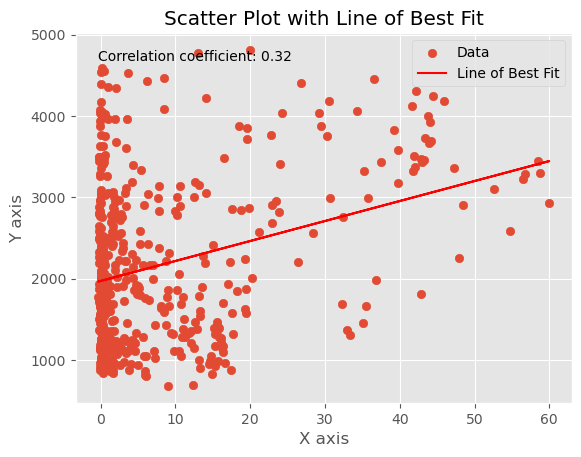

In [232]:
# Calculate the correlation coefficient
corr_coef, _ = pearsonr(x, y)

# Create a scatter plot
plt.scatter(x, y, label='Data')

# Fit a polynomial regression line (1st degree)
m, b = np.polyfit(x, y, 1)

# Plot the line of best fit
plt.plot(x, m*x + b, color='red', label='Line of Best Fit')

# Add correlation coefficient to the plot
plt.text(x.min(), y.max(), f'Correlation coefficient: {corr_coef:.2f}', fontsize=10, verticalalignment='top')

# Add labels and legend
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Scatter Plot with Line of Best Fit')
plt.legend()

# Show plot
plt.show()

LinAlgError: SVD did not converge in Linear Least Squares

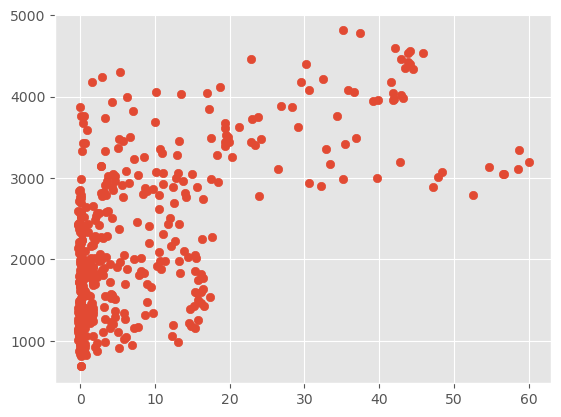

In [235]:
x, y = snowpack, large_hydro_shifted

# Calculate the correlation coefficient
#corr_coef, _ = pearsonr(x, y)

# Create a scatter plot
plt.scatter(x, y, label='Data')

# Fit a polynomial regression line (1st degree)
m, b = np.polyfit(x, y, 1)

# Plot the line of best fit
plt.plot(x, m*x + b, color='red', label='Line of Best Fit')

# Add correlation coefficient to the plot
#plt.text(x.min(), y.max(), f'Correlation coefficient: {corr_coef:.2f}', fontsize=10, verticalalignment='top')

# Add labels and legend
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.title('Scatter Plot with Line of Best Fit')
plt.legend()

# Show plot
plt.show()